In [ ]:
pip install 'git+https://github.com/facebookresearch/detectron2.git' # intstall in console alongside visual studio build tool c++ to run detectron2 wihtin env

In [4]:
import sys, os, distutils.core
import torch, detectron2

#!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.3 ; cuda:  2.3.1
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [43]:

from PIL import Image
import requests

In [44]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, r"C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs\labels_seg_2_labels_2024-06-17-01-30-05.json", r"C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs")
register_coco_instances("my_dataset_val", {}, r"C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs\labels_seg_2_labels_2024-06-17-01-30-05.json", r"C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs")


AssertionError: Dataset 'my_dataset_train' is already registered!

In [53]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[06/19 13:09:44 d2.data.datasets.coco]: Loaded 5 images in COCO format from C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs\labels_seg_2_labels_2024-06-17-01-30-05.json
[06/19 13:09:44 d2.data.datasets.coco]: Loaded 5 images in COCO format from C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\labels_imgs\labels_seg_2_labels_2024-06-17-01-30-05.json


In [54]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here

In [51]:

# Save the configuration to a config.yaml file
config_yaml_path = cfg.OUTPUT_DIR+"/config.yaml"
#config_yaml_path = "/content/gdrive/MyDrive/Colab_Notebook_3/Detectron2/Project_Jason_1/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [55]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)

[06/19 13:10:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


In [57]:
from PIL import Image
from pathlib import Path

input_images_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\Test_imgs'
output_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\Phase_mask'


for i, image_filename in enumerate(os.listdir(input_images_directory)):
    sys.stdout.write(f'\rSegmenting image {i+1} / {len(os.listdir(input_images_directory))}')
    sys.stdout.flush()
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.int16,)
                   for class_name in train_metadata.get("thing_classes")}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.get("thing_classes")[pred_class]
        instance_mask = outputs["instances"].pred_masks[i]
        class_masks[class_name] = torch.where(instance_mask,
                                      torch.tensor(i + 1, dtype=torch.float32),
                                      class_masks[class_name].to(dtype=torch.float32))
        class_masks[class_name] = class_masks[class_name].to(dtype=torch.int16)


    for class_name, class_mask in class_masks.items():
        class_mask_np = class_mask.cpu().numpy()
        image_name = Path(image_path).stem+'_mask.tif'
        Image.fromarray(class_mask_np.astype(np.uint16)).save(Path(output_directory) / image_name)

Segmenting image 12 / 12

Segmenting image 1 / 1

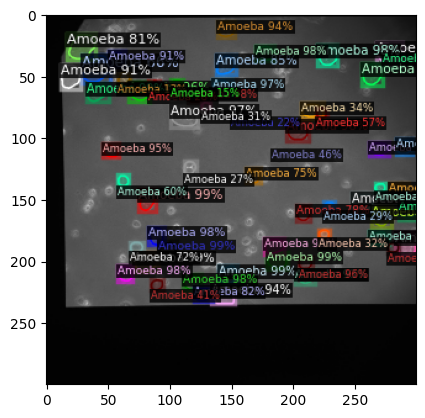

In [56]:
from detectron2.utils.visualizer import ColorMode

num_images =1
input_images_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Seg 2\Test_imgs'

for i, image_filename in enumerate(os.listdir(input_images_directory)[:num_images]):
    sys.stdout.write(f'\rSegmenting image {i+1} / {num_images}')
    sys.stdout.flush()
    image_path = os.path.join(input_images_directory, image_filename)
    im = cv2.imread(image_path)

    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW 
    )
   
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    #plt.savefig('test_seg.png')